In [7]:
from PIL import Image
import os
import torch
import hashlib
import tarfile
import requests
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [85]:
class LFWDataset(torch.utils.data.Dataset):
    _DATA = (
        # images
        ("http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz", None),
        # segmentation masks as ppm
        ("https://vis-www.cs.umass.edu/lfw/part_labels/parts_lfw_funneled_gt_images.tgz",
         "3e7e26e801c3081d651c8c2ef3c45cfc"),
    )


    def __init__(self, base_folder, transforms, download=True, split_name: str = 'train'):
        super().__init__()
        self.base_folder = base_folder
        # TODO your code here: if necessary download and extract the data
        '''
        if download:
            self.download_resources(base_folder)
        self.X = None
        self.Y = None
        raise NotImplementedError("Not implemented yet")'''
        if download:
            self.download_resources(base_folder)
        self.transforms = transforms
        self.split_name = split_name
        self.image_folder = os.path.join(base_folder, "lfw_funneled")
        #print(self.image_folder)
        self.mask_folder = os.path.join(base_folder, "parts_lfw_funneled_gt_images")
        #print(self.mask_folder)
        self.image_file_list, self.mask_file_list = self.get_file_lists()
        self.indices = self.get_split_indices()
            
    def get_file_lists(self):
        all_image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(self.image_folder) for f in filenames if f.endswith('.jpg')]

        mask_file_list = [f for f in os.listdir(self.mask_folder) if f.endswith('.ppm')]
        mask_file_list = [os.path.join(self.mask_folder, f) for f in mask_file_list if os.path.isfile(os.path.join(self.mask_folder, f))]
        
        image_mask_file_list = [f.replace('._','').replace('.ppm', '.jpg') for f in os.listdir(self.mask_folder) if f.endswith('.ppm')]
        image_mask_file_set = set(image_mask_file_list)
        
        image_file_list = [f for f in all_image_files if os.path.isfile(f) and f.split("\\")[-1] in image_mask_file_set]
        #print(all_image_files[0])
        #print(image_file_list[0])
        
        
        return image_file_list, mask_file_list

    def get_split_indices(self):
        num_samples = len(self.image_file_list)
        if self.split_name == 'train':
            return list(range(num_samples // 2))
        elif self.split_name == 'test':
            return list(range(num_samples // 2, num_samples))
        else:
            raise ValueError("Invalid split_name. Use 'train' or 'test'.")
        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # TODO your code here: return the idx^th sample in the dataset: image, segmentation mask
        # TODO your code here: if necessary apply the transforms
        # raise NotImplementedError("Not implemented yet")
        #print(self.image_file_list)
        image_filename = self.image_file_list[idx]
        maybe = image_filename.split("\\")[-1]
        maybe = maybe.replace('.jpg', '.ppm')
        #print(maybe)
        maybe2 = self.mask_folder + "\\" + maybe
        #print(maybe2)
        mask_filename = image_filename.replace('.jpg', '.ppm')
        mask_filename = maybe2

        #image_path = os.path.join(self.base_folder, image_filename)
        image_path = image_filename
        #mask_path = os.path.join(self.mask_folder, mask_filename)
        #print(mask_filename)
        mask_path = mask_filename
        #print(mask_path)
        
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        image = np.array(image)
        mask = np.array(mask)
        #print(mask)
        return image, mask

    def download_resources(self, base_folder):
        if not os.path.exists(base_folder):
            os.makedirs(base_folder)
        self._download_and_extract_archive(url=LFWDataset._DATA[1][0], base_folder=base_folder,
                                           md5=LFWDataset._DATA[1][1])
        self._download_and_extract_archive(url=LFWDataset._DATA[0][0], base_folder=base_folder, md5=None)

    def _download_and_extract_archive(self, url, base_folder, md5) -> None:
        """
          Downloads an archive file from a given URL, saves it to the specified base folder,
          and then extracts its contents to the base folder.

          Args:
          - url (str): The URL from which the archive file needs to be downloaded.
          - base_folder (str): The path where the downloaded archive file will be saved and extracted.
          - md5 (str): The MD5 checksum of the expected archive file for validation.
          """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)

        self._download_url(url, base_folder, md5)
        archive = os.path.join(base_folder, filename)
        print(f"Extracting {archive} to {base_folder}")
        self._extract_tar_archive(archive, base_folder, True)

    def _retreive(self, url, save_location, chunk_size: int = 1024 * 32) -> None:
        """
            Downloads a file from a given URL and saves it to the specified location.

            Args:
            - url (str): The URL from which the file needs to be downloaded.
            - save_location (str): The path where the downloaded file will be saved.
            - chunk_size (int, optional): The size of each chunk of data to be downloaded. Defaults to 32 KB.
            """
        try:
            response = requests.get(url, stream=True)
            total_size = int(response.headers.get('content-length', 0))

            with open(save_location, 'wb') as file, tqdm(
                    desc=os.path.basename(save_location),
                    total=total_size,
                    unit='B',
                    unit_scale=True,
                    unit_divisor=1024,
            ) as bar:
                for data in response.iter_content(chunk_size=chunk_size):
                    file.write(data)
                    bar.update(len(data))

            print(f"Download successful. File saved to: {save_location}")

        except Exception as e:
            print(f"An error occurred: {str(e)}")

    def _download_url(self, url: str, base_folder: str, md5: str = None) -> None:
        """Downloads the file from the url to the specified folder

        Args:
            url (str): URL to download file from
            base_folder (str): Directory to place downloaded file in
            md5 (str, optional): MD5 checksum of the download. If None, do not check
        """
        base_folder = os.path.expanduser(base_folder)
        filename = os.path.basename(url)
        file_path = os.path.join(base_folder, filename)

        os.makedirs(base_folder, exist_ok=True)

        # check if the file already exists
        if self._check_file(file_path, md5):
            print(f"File {file_path} already exists. Using that version")
            return

        print(f"Downloading {url} to file_path")
        self._retreive(url, file_path)

        # check integrity of downloaded file
        if not self._check_file(file_path, md5):
            raise RuntimeError("File not found or corrupted.")

    def _extract_tar_archive(self, from_path: str, to_path: str = None, remove_finished: bool = False) -> str:
        """Extract a tar archive.

        Args:
            from_path (str): Path to the file to be extracted.
            to_path (str): Path to the directory the file will be extracted to. If omitted, the directory of the file is
                used.
            remove_finished (bool): If True , remove the file after the extraction.
        Returns:
            (str): Path to the directory the file was extracted to.
        """
        if to_path is None:
            to_path = os.path.dirname(from_path)

        with tarfile.open(from_path, "r") as tar:
            tar.extractall(to_path)

        if remove_finished:
            os.remove(from_path)

        return to_path

    def _compute_md5(self, filepath: str, chunk_size: int = 1024 * 1024) -> str:
        with open(filepath, "rb") as f:
            md5 = hashlib.md5()
            while chunk := f.read(chunk_size):
                md5.update(chunk)
        return md5.hexdigest()

    def _check_file(self, filepath: str, md5: str) -> bool:
        if not os.path.isfile(filepath):
            return False
        if md5 is None:
            return True
        return self._compute_md5(filepath) == md5


[ 29  76 150]


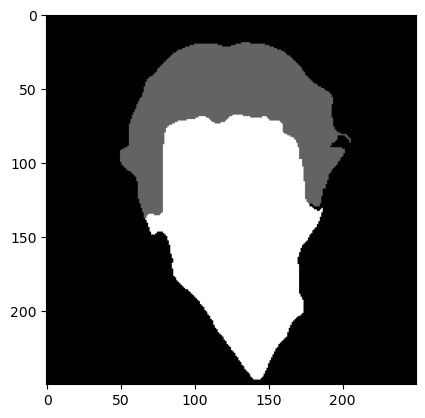

In [86]:
lfw_dataset = LFWDataset(download=False, base_folder='..\cvdl_lab_4\lfw_dataset', transforms=None)
index_to_inspect = 0
image, mask = lfw_dataset[index_to_inspect]
print(np.unique(mask))
plt.imshow(mask, cmap="gray")
plt.show()

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


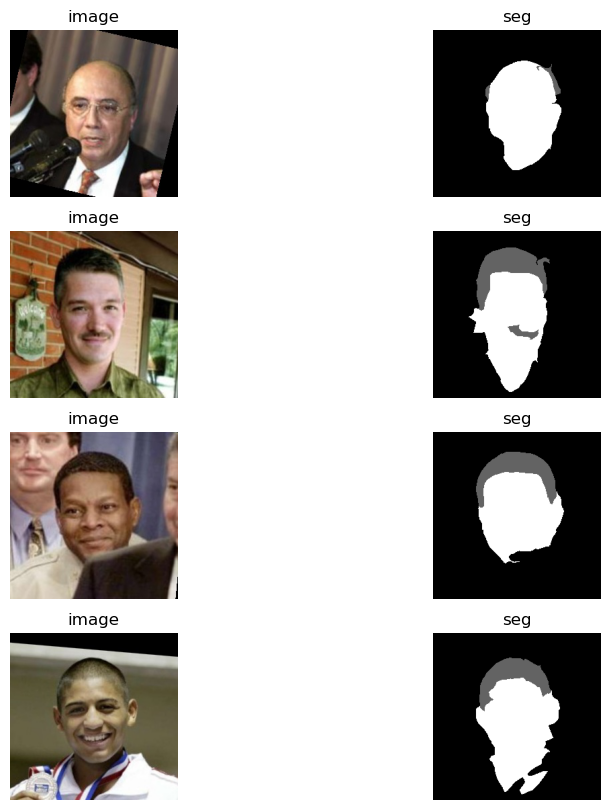

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


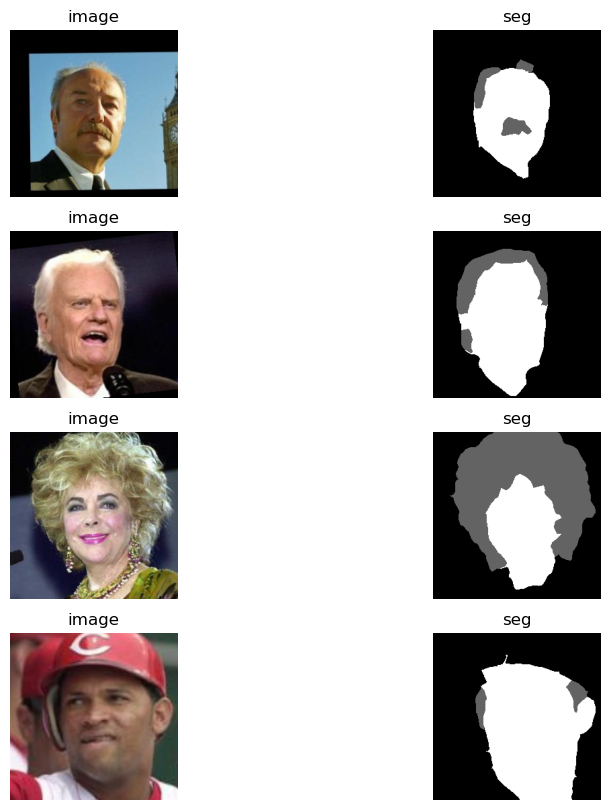

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


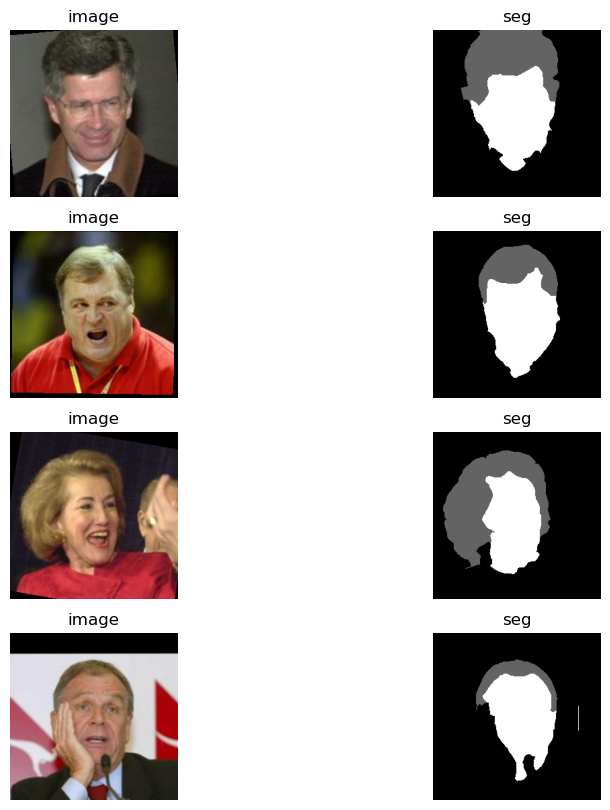

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


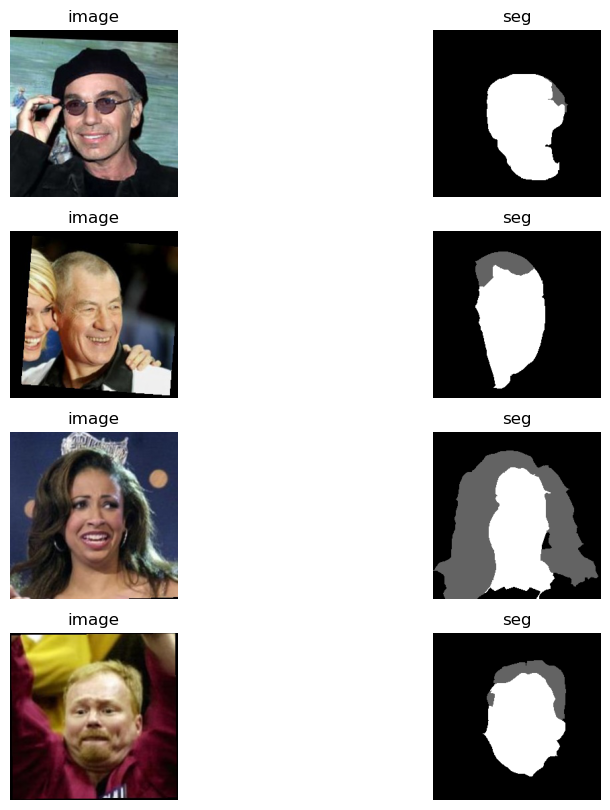

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


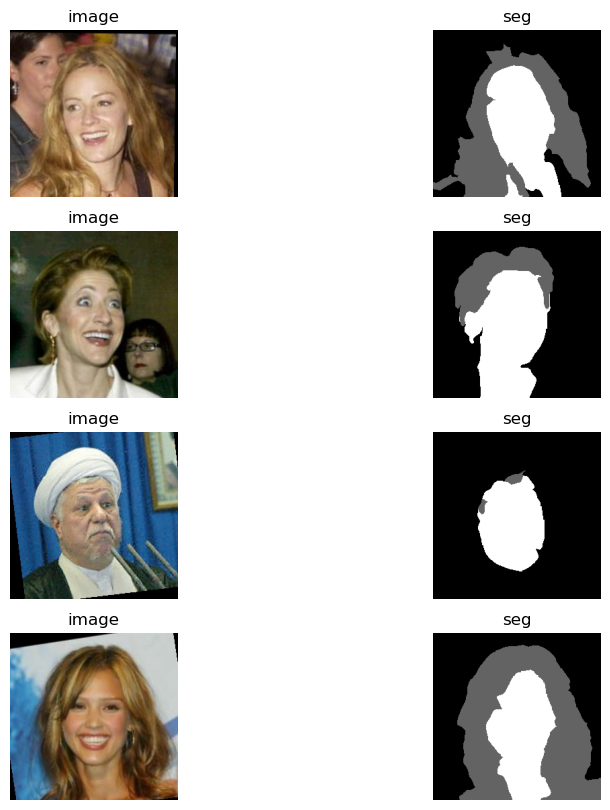

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


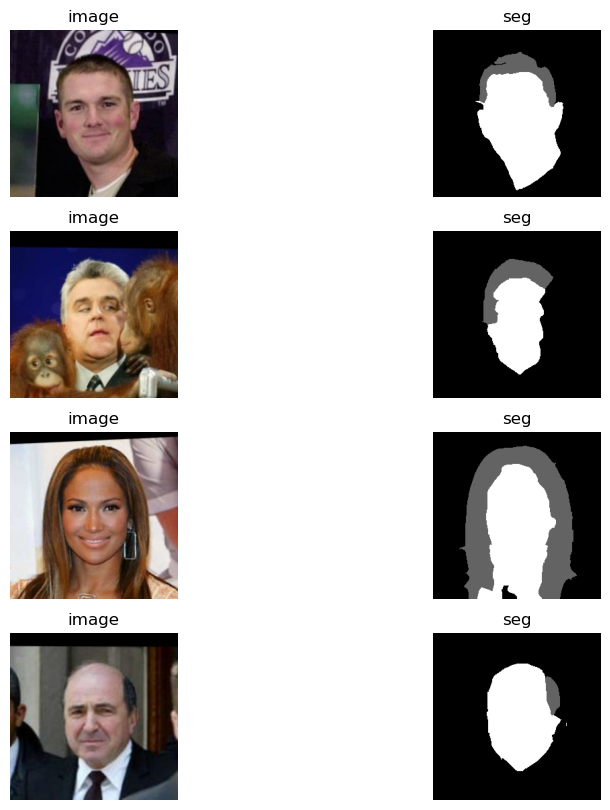

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


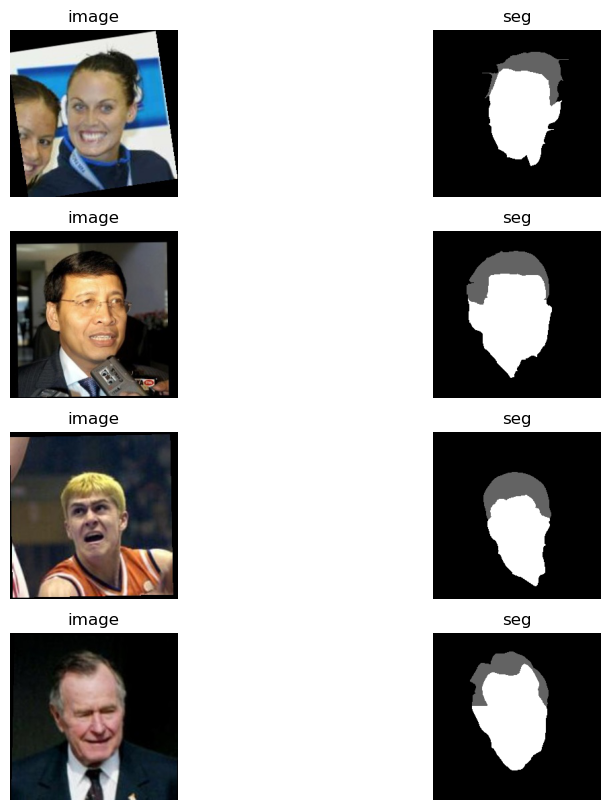

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


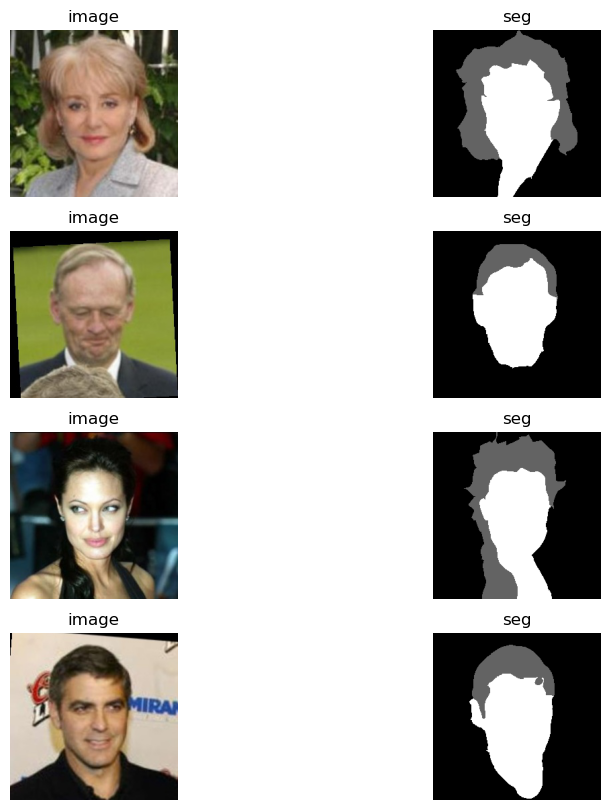

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


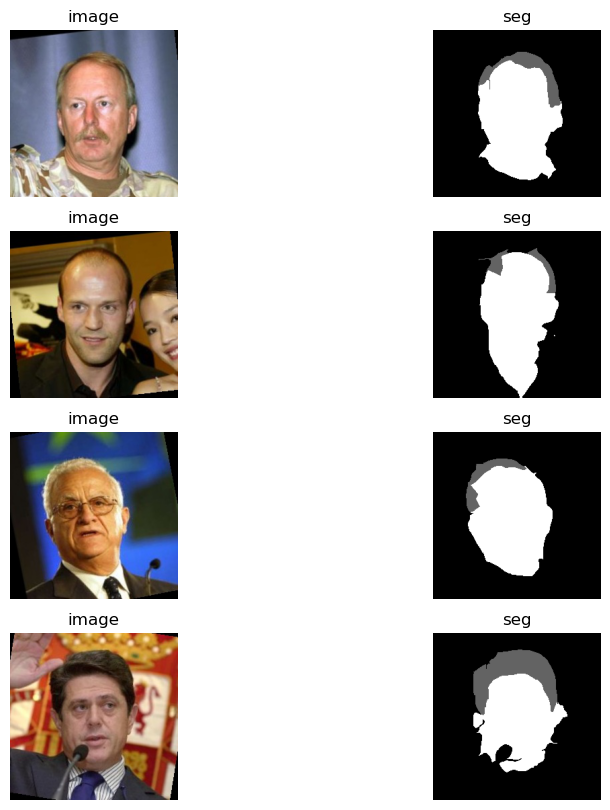

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


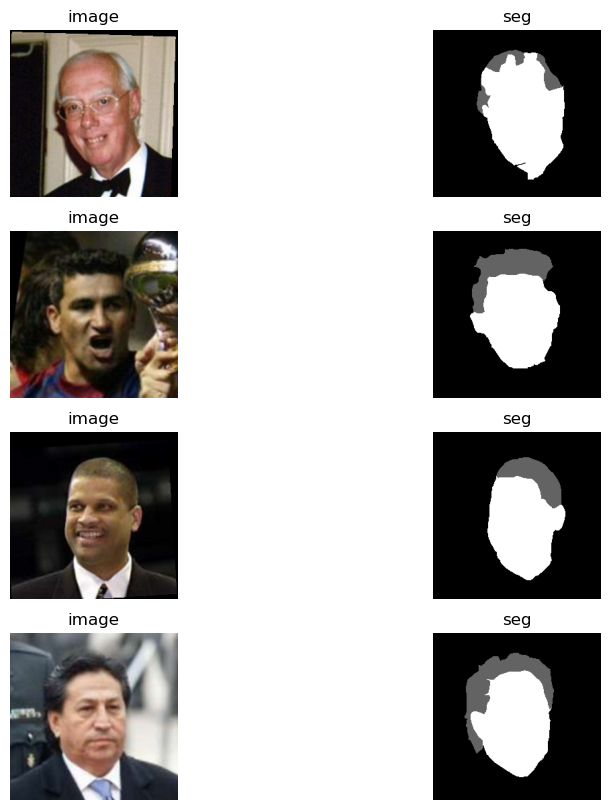

[ 29  76 150]
[ 29  76 150]
[ 29  76 150]
[ 29  76 150]


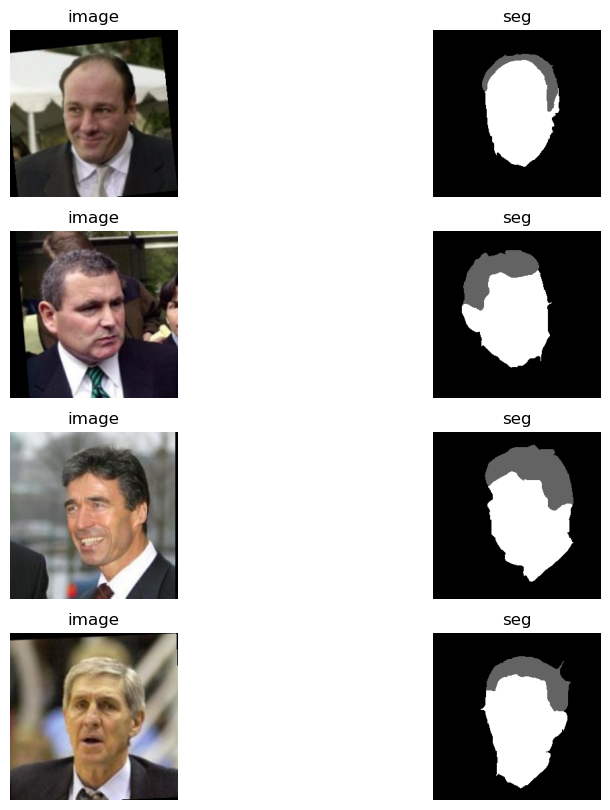

In [81]:
ds = LFWDataset(download=False, base_folder='..\cvdl_lab_4\lfw_dataset', transforms=None)
bs = 4
dataloader = torch.utils.data.DataLoader(ds, batch_size=bs, shuffle=True, num_workers=0)

for i_batch, sample_batched in enumerate(dataloader):
    imgs = sample_batched[0]
    segs = sample_batched[1]

    rows, cols = bs, 2
    figure = plt.figure(figsize=(10, 10))

    for i in range(0, bs):
        figure.add_subplot(rows, cols, 2*i+1)
        plt.title('image')
        plt.axis("off")
        plt.imshow(np.transpose(imgs[i].numpy(), (0, 1, 2)))

        figure.add_subplot(rows, cols, 2*i+2)
        plt.title('seg')
        plt.axis("off")
        plt.imshow(segs[i].squeeze().numpy(), cmap="gray")
        print(np.unique(segs[i]))

    plt.show()

    # display the first 1 batches
    if i_batch == 10:
        break